In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy.fftpack import dct

In [2]:
def zig_zag(input_matrix, block_size):
    z = np.empty(block_size*block_size)
    index = -1
    bound = 0
    for i in range(0, 2 * block_size -1):
        if i < block_size:
            bound = 0
        else:
            bound = i - block_size + 1
        for j in range(bound, i - bound + 1):
            index += 1
            if i % 2 == 1:
                z[index] = int(input_matrix[j, i-j])
            else:
                z[index] = int(input_matrix[i-j, j])
    return z[:16]

def euclidian(array1, array2):
    toplam = 0
    for i in range(len(array1)):
        toplam += (int(array1[i]) - int(array2[i])) ** 2
    
    return toplam ** 0.5

In [3]:
im = cv2.imread("f1.png", 0)
#im = cv2.imread("/home/user/Downloads/028_F.png", 0)
output_image = im
blok_boyutu = 8
yukseklik = im.shape[0]
genislik = im.shape[1]
bloklar = np.zeros((yukseklik, genislik, blok_boyutu, blok_boyutu))
dct_blogu = np.zeros_like(bloklar)
#benzerlik_yakinligi = 15
#yakinlik_esigi = 5
#cevre_esigi = 3
shift_vektorleri = []
quantalama_tablosu = np.array([1, 1, 1, 2, 1, 2, 4, 2, 2, 4, 8, 4, 2, 4, 8, 16])
#quantalama_tablosu = 16
zigzag_vektorleri = np.zeros((dct_blogu.shape[0] * dct_blogu.shape[1], 18))

In [ ]:
for i in range(yukseklik - blok_boyutu + 1):
    for j in range(genislik - blok_boyutu + 1):
        bloklar[i, j] = im[i : i + blok_boyutu, j : j + blok_boyutu]
        dct_blogu[i, j] = dct( dct( bloklar[i, j], type=3, axis=0 ), type=3, axis=1)
        zigzag_vektorleri[i * genislik + j][:16] = np.floor(zig_zag(dct_blogu[i, j], blok_boyutu) / quantalama_tablosu)
        zigzag_vektorleri[i * genislik + j][16] = i 
        zigzag_vektorleri[i * genislik + j][17] = j

In [ ]:
zigzag_vektorleri = zigzag_vektorleri.tolist()
zigzag_vektorleri = np.array(sorted(zigzag_vektorleri, key = lambda zigzag_vektorleri: zigzag_vektorleri[1]))

In [ ]:
# dist = numpy.linalg.norm(a-b)
bakilacak_vektor = 15
benzerlik_esigi = 100
yakinlik_esigi = 10
shift_esigi = 10

b = im

# im : 256 x 256
# bloklar : 256 x 256 x 8 x 8
# dct_blogu : 256 x 256 x 8 x 8
# Zigzag vektorleri : (256*256) x 18
for i in range(zigzag_vektorleri.shape[0] - bakilacak_vektor):
    for j in range(1, bakilacak_vektor):
        dist = euclidian(zigzag_vektorleri[i][:16], zigzag_vektorleri[i + j][:16])
        if(dist < benzerlik_esigi):
            if(i % 500 == 0):
                print("{}/{} satir tamamlandi".format(i, zigzag_vektorleri.shape[0]))
            yakinlikX = zigzag_vektorleri[i][16] - zigzag_vektorleri[i + j][16]
            yakinlikY = zigzag_vektorleri[i][17] - zigzag_vektorleri[i + j][17]
            if(((yakinlikX ** 2 + yakinlikY ** 2) ** 0.5) > yakinlik_esigi):
                shift_vektorleri.append([zigzag_vektorleri[i][16], zigzag_vektorleri[i][17], 
                                         zigzag_vektorleri[i + j][16], zigzag_vektorleri[i + j][17], 
                                         zigzag_vektorleri[i][16] - zigzag_vektorleri[i + j][16], 
                                         zigzag_vektorleri[i][17] - zigzag_vektorleri[i + j][17]])

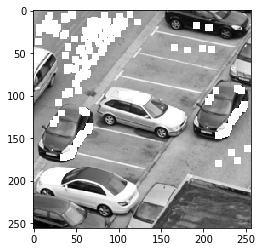

In [45]:
u, c = np.unique(np.array(shift_vektorleri)[:, -2:], return_counts=True)
dup = u[c > shift_esigi]
vektorler = []
for i in range(0, len(dup) - 1, 2):
    vektorler.append([dup[i], dup[i + 1]])

for i, j in vektorler:
    y = np.array(shift_vektorleri)[:, -2:] == [i, j]
    secilen_bloklar = np.unique(np.where(y)[0][:])
    for k in range(len(secilen_bloklar)):
        xDegeri = np.array(shift_vektorleri)[secilen_bloklar][k][0]
        yDegeri = np.array(shift_vektorleri)[secilen_bloklar][k][1]
        x2Degeri = np.array(shift_vektorleri)[secilen_bloklar][k][2]
        y2Degeri = np.array(shift_vektorleri)[secilen_bloklar][k][3]
        b[int(xDegeri) : int(xDegeri) + blok_boyutu, 
            int(yDegeri) : int(yDegeri) + blok_boyutu] = 255            
        b[int(x2Degeri) : int(x2Degeri) + blok_boyutu, 
            int(y2Degeri) : int(y2Degeri) + blok_boyutu] = 255            

plt.figure()
plt.imshow(b, cmap="gray")

6738 degerde 1654 tanesi bulundu
Dogruluk = 0.2454734342534877


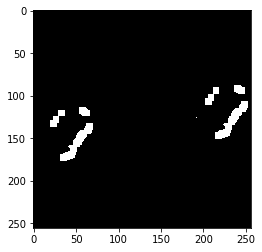

In [46]:
ground_truth = cv2.imread("forged1_maske.png", 0)
c = np.zeros_like(b)
eslesme = 0
toplam_deger = np.unique(ground_truth, return_counts=True)[1][1]
for i in range(ground_truth.shape[0]):
    for j in range(ground_truth.shape[1]):
        if((ground_truth[i, j] == b[i, j]) and (ground_truth[i, j] == 255)):
            eslesme += 1
            c[i, j] = 128
plt.figure()
plt.imshow(c, cmap="gray")
print("{} degerde {} tanesi bulundu".format(toplam_deger, eslesme))
print("Dogruluk = {}".format(eslesme/toplam_deger))